In [5]:
import cv2 as cv
import numpy as np
from skimage.feature import blob_log
import matplotlib.pyplot as plt
from math import sqrt

# Read the image
img = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv.GaussianBlur(gray, (9, 9), 0.1)
laplacian = cv.Laplacian(blurred, cv.CV_64F)

# Define parameters for blob detection
min_sigma = 3
max_sigma = 10
threshold = 4

# Detect blobs using Laplacian of Gaussians
blobs = blob_log(laplacian, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold)
blobs[:, 2] = blobs[:, 2] * sqrt(2)

# Find the largest circle by comparing their radii
if len(blobs) > 0:
    max_radius_index = np.argmax(blobs[:, 2])
    largest_circle_params = blobs[max_radius_index]
    y, x, r = largest_circle_params
    print(f"Largest Circle Parameters:")
    print(f"Radius (r): {r}")
    print(f"Center (x, y): ({x}, {y})")
else:
    print("No circles detected.")

# Report the range of σ values used
print(f"Range of σ values used: Min = {min_sigma}, Max = {max_sigma}")

# Draw circles on the original grayscale image
for blob in blobs:
    y, x, r = blob  # Blob format is (y, x, r)
    cv.circle(img, (int(x), int(y)), int(r), (0, 0, 255), thickness=1, lineType=cv.LINE_AA)  # Draw circles in white

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Circles with Smooth Edges')
plt.show()


ModuleNotFoundError: No module named 'skimage'

Problem 1

Parameters of the largest circle:
Center: (251, 175)
Radius: 13
Range of σ values used: 0.01 to 6.609999999999999


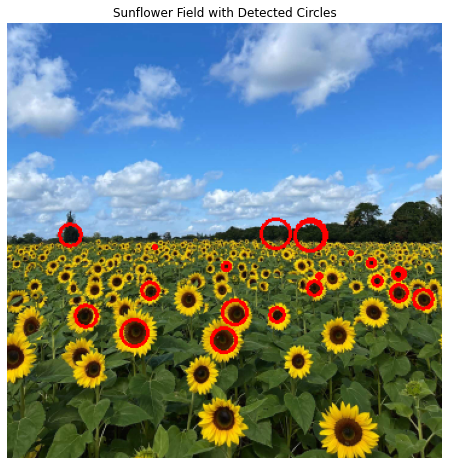

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)


# Variables
min_radius = 1  # Minimum circle radius
max_radius = 600 # Maximum circle radius
sigma_values = np.arange(0.01, 6.9, 0.3)  # Range of sigma values to use

# Initialize an empty list to store detected circles
circles = []

for sigma in sigma_values:
    # Apply Gaussian blur with the current sigma
    blurred = cv.GaussianBlur(gray, (0, 0), sigmaX=sigma)
    
    # Apply Laplacian of Gaussian (LoG) to find zero-crossings
    log = cv.Laplacian(blurred, cv.CV_64F)
    
    # Find the local extrema in the LoG image
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(log)
    
    # Threshold the LoG image to detect extrema
    threshold = 0.3
    if max_val > threshold:
        radius = int(sigma * 2)
        
        if min_radius <= radius <= max_radius:
            circles.append((max_loc[0], max_loc[1], radius))


circles.sort(key=lambda x: x[2], reverse=True)

largest_circle = circles[0]

center_x, center_y, radius = largest_circle

print("Parameters of the largest circle:")
print(f"Center: ({center_x}, {center_y})")
print(f"Radius: {radius}")
print(f"Range of σ values used: {sigma_values[0]} to {sigma_values[-1]}")


im_with_circles = im_rgb.copy()
# Draw circles on the copy of the image
for circle in circles:
    center_x, center_y, radius = circle
    cv.circle(im_with_circles, (center_x, center_y), radius, (255, 0, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(im_with_circles)
plt.title("Sunflower Field with Detected Circles")
plt.axis("off")
plt.show()


Problem 2

Problem 03

H=  [[6.37627150e-01 5.38855398e-01 2.47000000e+02]
 [1.00902221e-01 1.84862253e+00 3.07000000e+02]
 [2.07620581e-04 1.90617284e-03 1.00000000e+00]]


Text(0.5, 1.0, 'Overlayed Image')

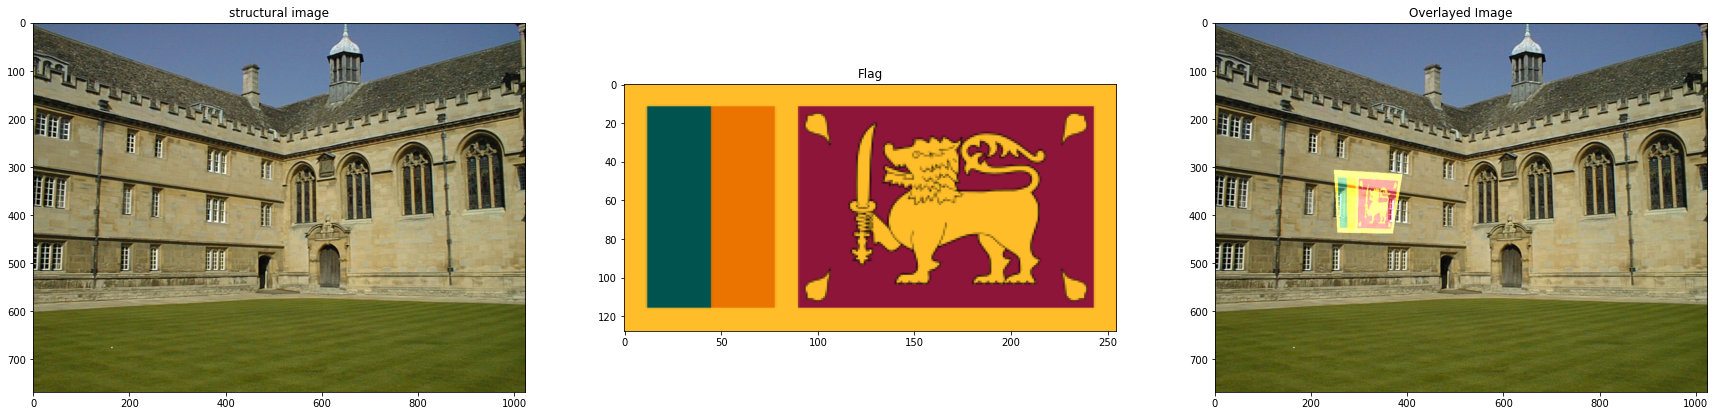

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
#Mouse clicking

k = 0
def mousePoint(event, x,y,flags,params):
    if event == cv.EVENT_LBUTTONDOWN:
        imgPoints.append([x,y,1])


def Homography(imgPoints, flagPoints):
    A = []
    for i in range(4):
        A.append([flagPoints[i][0],flagPoints[i][1],flagPoints[i][2],0,0,0,
        -imgPoints[i][0]*flagPoints[i][0],-imgPoints[i][0]*flagPoints[i][1],-imgPoints[i][0]*flagPoints[i][2]])
        A.append([0,0,0,flagPoints[i][0],flagPoints[i][1],flagPoints[i][2],
        -imgPoints[i][1]*flagPoints[i][0],-imgPoints[i][1]*flagPoints[i][1],-imgPoints[i][1]*flagPoints[i][2]])
    A = np.array(A,dtype = np.float64)
    AAT = A.T @ A
    w, v = np.linalg.eig(AAT)
    H = v[:, np.argmin(w)]
    H = H.reshape((3,3))
    H = H/H[-1,-1]
    return H

img = cv.imread('001.jpg',cv.IMREAD_ANYCOLOR)
cv.imshow("IMG",img)
imgPoints = []
cv.setMouseCallback("IMG",mousePoint)
k = cv.waitKey(0)
if k ==ord('q'): 
    cv.destroyAllWindows()


imgFlag = cv.imread('sl.png',cv.IMREAD_ANYCOLOR)
flagheight,flagWidth = imgFlag.shape[0],imgFlag.shape[1]
flagPoints = np.array([[0,0,1],[flagWidth,0,1],[flagWidth,flagheight,1],[0,flagheight,1]])
imgPoints = np.array(imgPoints)
H = Homography(imgPoints,flagPoints)
print('H= ',H)

rows,cols,ch = img.shape
warpedImg = cv.warpPerspective(imgFlag,H,(cols,rows))
overlayImg = cv.add(img, warpedImg)
fig,ax = plt.subplots(1,3,figsize = (30,15))
warpedImg = cv.cvtColor(warpedImg, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
imgFlag = cv.cvtColor(imgFlag, cv.COLOR_BGR2RGB)
overlayImg = cv.cvtColor(overlayImg, cv.COLOR_BGR2RGB)

ax[0].imshow(img)
ax[0].set_title("structural image")
ax[1].imshow(imgFlag)
ax[1].set_title("Flag")
ax[2].imshow(overlayImg)
ax[2].set_title("Overlayed Image")

Problem 4

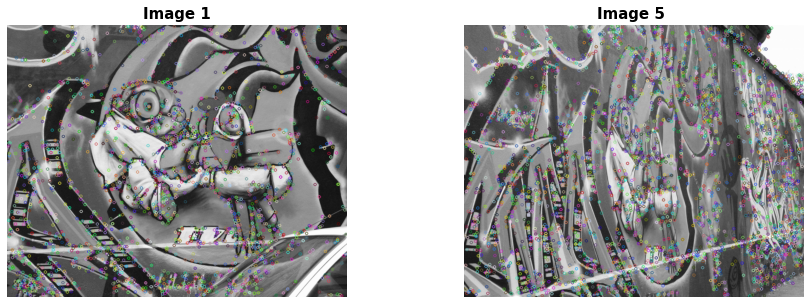

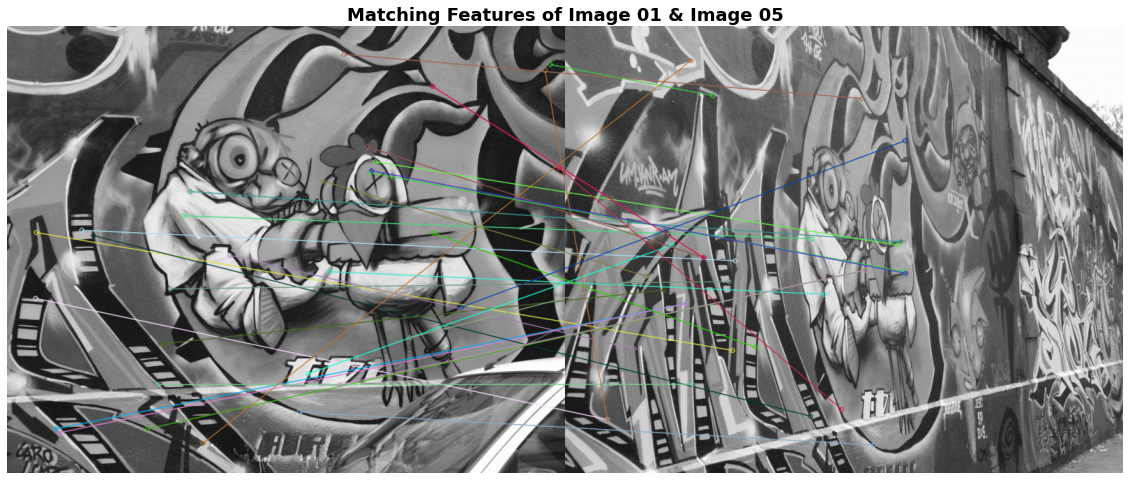

In [13]:
im1 = cv.imread(r"D:\Acadamics\semester 5\Image Processing - 3\A02 Fitting and Alignment\A02-Fitting-and-Alignment\Graf\img1.ppm", cv.IMREAD_GRAYSCALE)
im5 = cv.imread(r"D:\Acadamics\semester 5\Image Processing - 3\A02 Fitting and Alignment\A02-Fitting-and-Alignment\Graf\img5.ppm", cv.IMREAD_GRAYSCALE)


# Create a SIFT object
sift = cv.SIFT_create()

# Detect and compute keypoints and descriptors for both images
kp1, descs1 = sift.detectAndCompute(im1, None)
kp2, descs2 = sift.detectAndCompute(im5, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=100)

# Create a FLANN matcher
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descs1, descs2, k=2)

# Apply ratio test to get good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Draw good matches on a new image
im3 = cv.drawMatches(im1, kp1, im5, kp2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Create images with keypoints drawn
kp_im_1 = cv.drawKeypoints(im1, kp1, None)
kp_im_5 = cv.drawKeypoints(im5, kp2, None)

# Display the images
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(cv.cvtColor(kp_im_1, cv.COLOR_BGR2RGB))
ax[0].set_title("Image 1", fontweight="bold", fontsize=15)
ax[0].axis("off")

ax[1].imshow(cv.cvtColor(kp_im_5, cv.COLOR_BGR2RGB))
ax[1].set_title("Image 5 ", fontweight="bold", fontsize=15)
ax[1].axis("off")
plt.show()

# Display the matching features
fig = plt.figure(figsize=(20, 20))
plt.imshow(cv.cvtColor(im3, cv.COLOR_BGR2RGB))
plt.title("Matching Features of Image 01 & Image 05", fontweight="bold", fontsize=18)
plt.axis('off')
plt.show()


In [18]:
def randN(n, t):
    l = np.random.randint(n, size=t)
    m = np.zeros(np.shape(l))
    
    for i in range(len(l)):
        m[i] = np.sum(l==l[i])
    if np.sum(m) == len(m):
        return l
    else:
        return randN(n,t)

def compute_Homography(from_Pt, to_Pt):
    
    X1, Y1, X2, Y2, X3, Y3, X4, Y4 = to_Pt[0], to_Pt[1], to_Pt[2], to_Pt[3], to_Pt[4], to_Pt[5], to_Pt[6], to_Pt[7]
    X1T, X2T, X3T, X4T = from_Pt[0], from_Pt[1], from_Pt[2], from_Pt[3]
    z_mat = np.array([[0],[0],[0]])
    
    m = np.concatenate((z_mat.T,X1T, -Y1*X1T), axis=1)
    n = np.concatenate((X1T,z_mat.T, -X1*X1T), axis=1)

    o = np.concatenate((z_mat.T,X2T, -Y2*X2T), axis=1)
    p = np.concatenate((X2T,z_mat.T, -X2*X2T), axis=1)

    q = np.concatenate((z_mat.T,X3T, -Y3*X3T), axis=1)
    r = np.concatenate((X3T,z_mat.T, -X3*X3T), axis=1)

    s = np.concatenate((z_mat.T,X4T, -Y4*X4T), axis=1)
    t = np.concatenate((X4T,z_mat.T, -X4*X4T), axis=1)

    A = np.concatenate((m,n,o,p,q,r,s,t), axis=0, dtype = np.float32)
    W,V = np.linalg.eig((A.T)@A)
    temp = V[:, np.argmin(W)]
    K = temp.reshape((3,3))
    return K


im2 = cv.imread(r"D:\Acadamics\semester 5\Image Processing - 3\A02 Fitting and Alignment\A02-Fitting-and-Alignment\Graf\img2.ppm")
im3 = cv.imread(r"D:\Acadamics\semester 5\Image Processing - 3\A02 Fitting and Alignment\A02-Fitting-and-Alignment\Graf\img3.ppm")
im4 = cv.imread(r"D:\Acadamics\semester 5\Image Processing - 3\A02 Fitting and Alignment\A02-Fitting-and-Alignment\Graf\img4.ppm")

images = [im1, im2, im3, im4, im5]

In [19]:
g, h = 0.99, 0.5
N = int(np.ceil(np.log(1-g)/np.log(1-((1-h)**4))))

H = []
for t in range(4):
    sift = cv.SIFT_create()
    kp1, decs1= sift.detectAndCompute(images[t],None)
    kp2, decs2 = sift.detectAndCompute(images[t+1],None)

    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)

    matches = bf.match(decs1,decs2)
    matches = sorted(matches, key = lambda x:x.distance)

    lst_kp1 = [kp1[mat.queryIdx].pt for mat in matches] 
    lst_kp2 = [kp2[mat.trainIdx].pt for mat in matches]

    t_h, I, b_H = 2, 0, 0

    for k in range(N):
        rand_pts = randN(len(lst_kp1)-1,4)

        from_Pt = []
        for i in range(4):
            from_Pt.append(np.array([[lst_kp1[rand_pts[i]][0], lst_kp1[rand_pts[i]][1], 1]]))

        to_Pt = []
        for j in range(4): 
            to_Pt.append(lst_kp2[rand_pts[j]][0])
            to_Pt.append(lst_kp2[rand_pts[j]][1])
        
        inliers = 0
        for i in range(len(lst_kp1)):
            X = [lst_kp1[i][0], lst_kp1[i][1], 1]
            hX = compute_Homography(from_Pt, to_Pt)@X
            hX /= hX[-1]
            error = np.sqrt(np.power(hX[0]-lst_kp2[i][0],2) + np.power(hX[1]-lst_kp2[i][1],2))
            if error < t_h: inliers+=1
        
        if inliers > I:
            I = inliers
            b_H = compute_Homography(from_Pt, to_Pt)

    H.append(b_H)

TypeError: concatenate() got an unexpected keyword argument 'dtype'

In [16]:
H_1_to_5 = H[3] @ H[2] @ H[1] @ H[0]
H_1_to_5 /= H_1_to_5[-1][-1]

trans = cv.warpPerspective(im1, H_1_to_5 ,(np.shape(im5)[1] ,np.shape(im5)[0]))

fig, ax = plt.subplots(2,2,figsize=(15,15))
ax[0][0].imshow(cv.cvtColor(im1,cv.COLOR_BGR2RGB))
ax[0][0].set_title("Image 1",fontweight ="bold",fontsize = 15)
ax[0][0].axis("off")

ax[0][1].imshow(cv.cvtColor(im5,cv.COLOR_BGR2RGB))
ax[0][1].set_title("Image 5",fontweight ="bold",fontsize = 15)
ax[0][1].axis("off")

ax[1][0].imshow(cv.cvtColor(trans, cv.COLOR_BGR2RGB))
ax[1][0].set_title("Transformed Image 1",fontweight ="bold",fontsize = 15)
ax[1][0].axis("off")

output = cv.add(im5,trans)
ax[1][1].imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
ax[1][1].set_title("Stitched Image 1 on Image 5",fontweight ="bold",fontsize = 15)
ax[1][1].axis("off")
plt.show()

IndexError: list index out of range